# QuDPy example notebook

## importing the required files

In [2]:
from qutip import *  # for quantum dynamics
import numpy as np  # for numerical manipulations
from qudpy.Classes import *  # for nonlinear spectroscpy
import qudpy.plot_functions as pf  # for plotting nonlinear spectra
import ufss  # for double-sided diagram generation

the rephasing diagrams are R1, R2 and R3  (('Bu', 0), ('Ku', 1), ('Bd', 2)) (('Bu', 0), ('Bd', 1), ('Ku', 2)) (('Bu', 0), ('Ku', 1), ('Ku', 2))


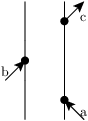

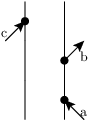

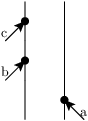

In [3]:

# Setting up the required double sided diagrams for tests
# DiagramGenerator class, or DG for short
DG = ufss.DiagramGenerator
# initialize the module
R3rd = DG()  # DG takes a single key-word argument, which has the default value detection_type = 'polarization'
# DiagramAutomation needs to know the phase-matching/-cycling condition
R3rd.set_phase_discrimination([(0, 1), (1, 0), (1, 0)])  # setting phase-matching condition for rephasing diagrams R1,2,3
# Set the pulse durations for pulses 0,1,2 and the local oscillator
d0 = 2
d1 = 4
d2 = 4
dlo = 6
# Set the pulse intervals
t0 = np.array([-d0 / 2, d0 / 2])
t1 = np.array([-d1 / 2, d1 / 2])
t2 = np.array([-d2 / 2, d2 / 2])
tlo = np.array([-dlo / 2, dlo / 2])
all_pulse_intervals = [t0, t1, t2, tlo]

# These pulse intervals are given to DG by setting DG's efield_times attribute
R3rd.efield_times = all_pulse_intervals
time_ordered_diagrams_rephasing = R3rd.get_diagrams([0, 100, 200, 200]) # selecting pulse arrival times to ensure no pulses overlap.
[R3, R1, R2] = time_ordered_diagrams_rephasing
rephasing = [R1, R2, R3]
print('the rephasing diagrams are R1, R2 and R3 ', R1, R2, R3)
R3rd.display_diagrams(rephasing)

## Setting up the system

A physical system with associated operators, density matrix and Hamiltonian is initialized using Qutip using the System() command. 


The default values of the system are:

 * number of energy levels = n = (ground state + two excited states) = 3
 * lowering operator for 3 level-system =  a
 * Hamiltonian  $H = \hbar\omega a^\dagger a$  with  $\hbar \omega =2 eV$  and  $\hbar$ in units of eV fs.
 * collapse operators, c_opts=[ ] (system is isolated if left blank, other wise include list of Lindblad ops)
 * dipole =  $\hat \mu =\mu(a^\dagger +a)$  with  $\mu=1$
 * starting density matrix in the ground state =  $\rho$ 
 
These opertors uniquely define the system and its interaction with the environment.

Therefore, these values can be externally defined and passed to the System( ) for creating a particular configuration.



In [4]:
sys1 = System()

system initialized


Consider the example below for a 3-level Harmonic system with E=2.3 eV, starting in the 2nd excited state

In [5]:
hbar = 0.658211951  # eV fs
E = 2.3  # eV
w = E/hbar  # frequency
a = destroy(3)
H = hbar*w*a.dag()*a
rho = fock_dm(3, 2)

sys2 = System(n=3, H=H, rho=rho, c_ops=[], a=a, u=a.dag()+a)

system initialized


At this point, the Hamiltonian for the dynamics is fully specified.  In principle, one can do further analysis and calculations, such as determine the eigenvalues, etc.  However, since we're interested in spectroscopy, we'll do that.

For the simple 3-level harmonic system starting in the ground state, a single evolution through a given double-sided diagram can be realized and inspected by the diagram_donkey function of the system.

The required inputs for this function are

 * A list of light-matter interaction times.
 * A list of double-sided diagrams
 * Time resolution for the simulation as time steps per femto-second
 
Outputs a plot of the expectation value for the dipole and the number of excitations for the system.

total diagrams 1 , total interactions  3
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)


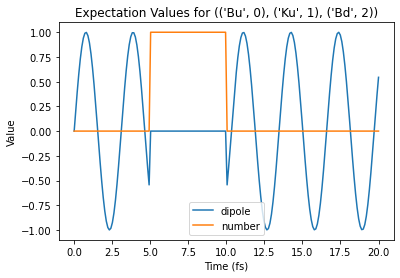

In [6]:
states = sys1.diagram_donkey([0, 5, 10, 20], [R1], r=10)

This shows that at time (t=0) the light-matter interaction creates a coherence, at t = 5 fs, the pulse localizes the system into a population state $|1\rangle\langle 1 |$, at t = 10 fs, the 3rd pulse creates a coherence, and then the final polarization is observed at 20 fs. 

# A non-trivial example

For this, let's set the Hamiltonian to be 2 coupled oscillators: 

$$H/\hbar = \omega_1 a^\dagger a + \omega_2 (b^\dagger b +s(b^\dagger + b)) + J(a^\dagger b + b^\dagger a)$$

note that we'll use 2 quanta in each, for a fock-space of dimension 4.
Furthermore, we want to include relaxation within each subspace.


In [7]:
hbar = 0.658211951  # eV fs
E1 = 2  # eV
E2 = 2.1 #eV
w1 = E1/hbar  # frequency
w2 = E2/hbar  # frequency
J = 0.3/hbar  # coupling
s2 = 0.1  # relative huang-rhys factor between the two oscillators


mu1 = 1.0  # dipole operator
mu2 = 1.0  # dipole operator

# for multiple degrees of freedom, the quantum operators need to be defined as tensor operators:

a = tensor(destroy(2),qeye(2))
b = tensor(qeye(2),destroy(2))

# we now construct the full Hamiltonian consisting of 2 HO's + an exchange term:

H = hbar*(w1*a.dag()*a + w2*(b.dag()*b + s2*(b.dag()+b)) + J*(a.dag()*b + b.dag()*a))

H += 0.1*a.dag()*a.dag()*a*a

In [8]:
# Specify the Lindblad relaxation terms.
          
kappa = 0.5  # internal relaxation rate

kB=8.617333262e-5# eV/K

T= 300  # temperature in K
kT = T*kB
beta = 1/kT

          
n1 = 1/(np.exp(hbar*w1*beta)-1)  #<n1>
n2 = 1/(np.exp(hbar*w2*beta)-1)  #<n2>
r1 = kappa*(n1+1)
r2 = kappa*(n2+1)

c1=np.sqrt(kappa*(n1+1))*a
c2=np.sqrt(kappa*(n2+1))*b

c3=np.sqrt(kappa*n1)*a.dag()
c4=np.sqrt(kappa*n2)*b.dag()


In [9]:
en,T = H.eigenstates()

In [10]:
Hd=H.transform(T)
c1d =c1.transform(T)
c2d =c2.transform(T)
c3d =c3.transform(T)
c4d =c4.transform(T)
mu = (a+a.dag()) +(b+b.dag())
A = (a+b).transform(T)
mud = mu.transform(T)

#define density matrix in eigenbasis
psi0 = tensor(fock(2,0),fock(2,0))
rho = psi0*psi0.dag()

In [12]:
from qudpy.Classes import *
sys3 = System(H=H,a=(a+b), u=mu,c_ops=[c1,c2,c3,c4],rho=rho, diagonalize=True)

diagonalizing Hamiltonian and transforming everything into eigen-basis except rho
system initialized


In [13]:
sys2 = System(H=Hd,a=A,u=mud,c_ops=[c1d,c2d,c3d,c4d],rho=rho)

system initialized


total diagrams 1 , total interactions  3
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)


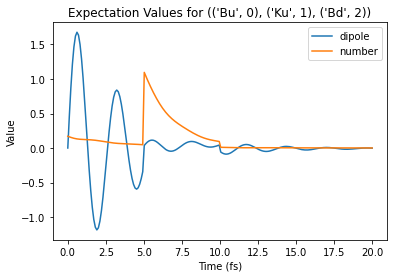

In [14]:
states = sys2.diagram_donkey([0, 5, 10, 20], [R1], r=10)

total diagrams 1 , total interactions  3
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)


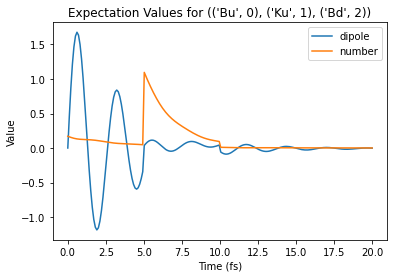

In [15]:
states = sys3.diagram_donkey([0, 5, 10, 20], [R1], r=10)

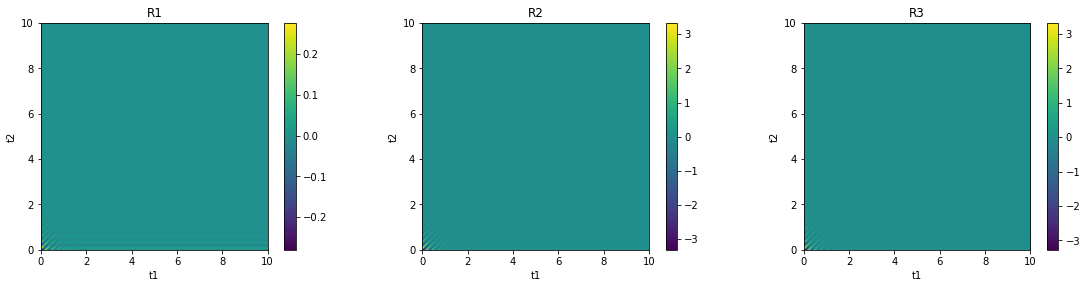

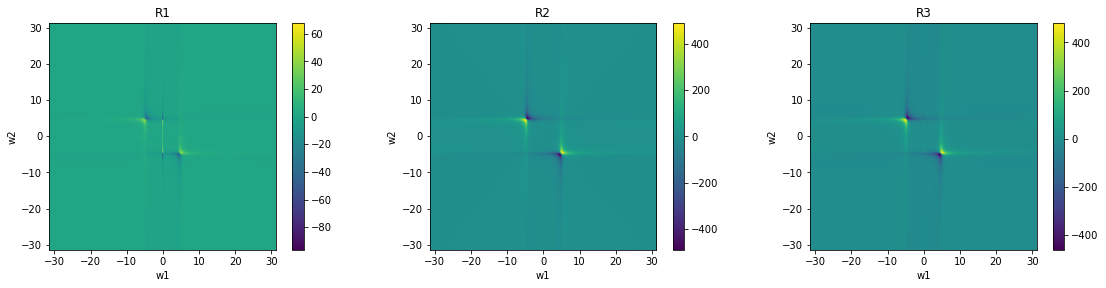

In [16]:
time_delays = [100, 5, 100]
scan_id = [0, 2]
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys2.coherence2d(time_delays, rephasing[k], scan_id,r=5, parallel=True)
    response_list.append(np.imag(dipole))

spectra_list, extent, f1, f2 = sys2.spectra(response_list)
                                            # Uncomment the lines below to plot the time domain dipole signal
pf.multiplot(response_list, [0, 10, 0, 10], ['t1', 't2'], ['R1', 'R2', 'R3'], 'linear')
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w2'], ['R1', 'R2', 'R3'], 'linear')

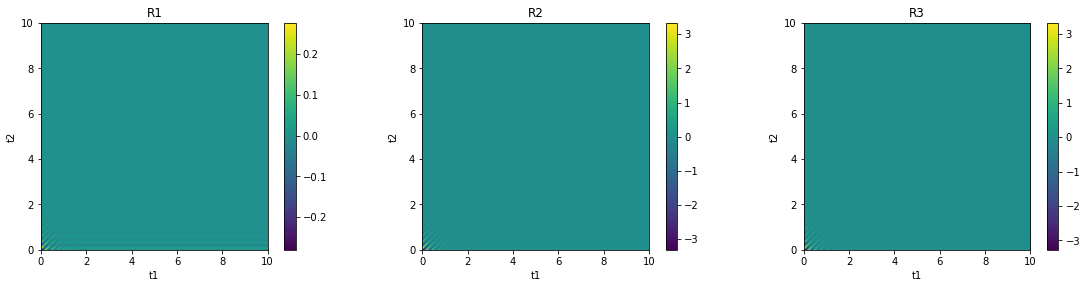

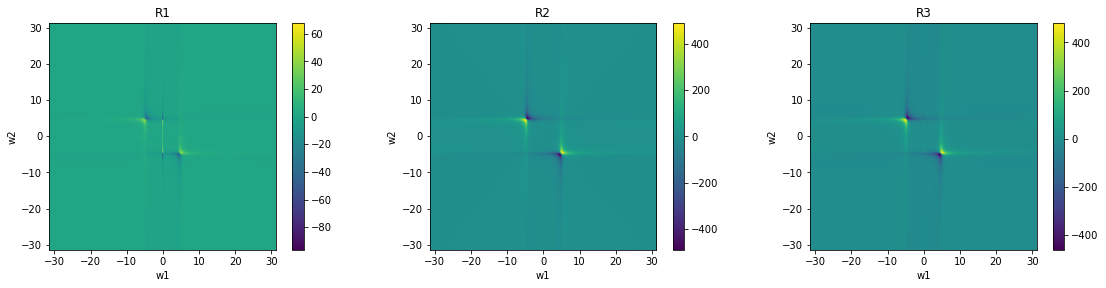

In [17]:
time_delays = [100, 5, 100]
scan_id = [0, 2]
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys3.coherence2d(time_delays, rephasing[k], scan_id,r=5, parallel=True)
    response_list.append(np.imag(dipole))

spectra_list, extent, f1, f2 = sys3.spectra(response_list)
# Uncomment the lines below to plot the time domain dipole signal
pf.multiplot(response_list, [0, 10, 0, 10], ['t1', 't2'], ['R1', 'R2', 'R3'], 'linear')
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w2'], ['R1', 'R2', 'R3'], 'linear')